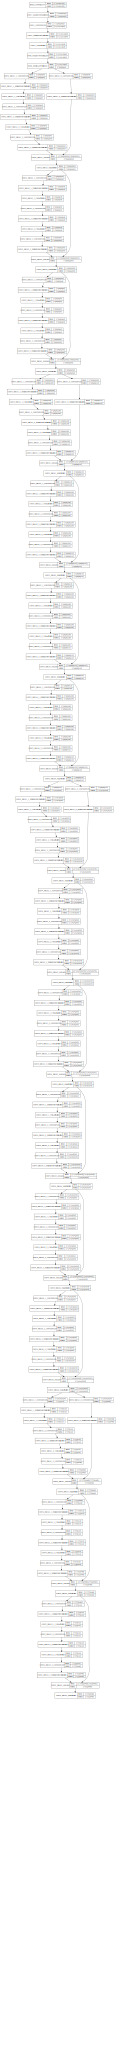

In [30]:
import tensorflow as tf
import pydot
import graphviz

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAvgPool2D, Add, ReLU, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
def printModel(model):
    return SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=60, subgraph=False).create(prog='dot',format='svg'))

printModel(res_net)



In [145]:
#Conv-BatchNorm-ReLU block
def convBlock(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [146]:
#Identity block
def identityBlock(tensor, filters):
    x = convBlock(tensor, filters=filters, kernel_size=1, strides=1)
    x = convBlock(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    x = Add()([tensor, x])
    x = ReLU()(x)
    return x

In [150]:
#Projection block 
def projectionBlock(tensor, filters, strides=1):
    #left stream
    x = convBlock(tensor, filters, kernel_size=1, strides=strides)
    x = convBlock(x, filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides = 1)(x)
    x = BatchNormalization()(x)
    
    #right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([shortcut, x])
    x = ReLU()(x)
    return x


In [151]:
#Resnet block
def resnetBlock(x, filters, reps, strides):
    x = projectionBlock(x, filters, strides)
    for _ in range(reps - 1):
        x = identityBlock(x, filters)
    return x


In [154]:
#Model
input = Input(shape=(224,224,3))
x = convBlock(input, filters=64, kernel_size=7, strides=2)
x = MaxPool2D(pool_size=3, strides=2)(x)
x = resnetBlock(x, filters=64, reps=3, strides=1)
x = resnetBlock(x, filters=128, reps=4, strides=2)
x = resnetBlock(x, filters=256, reps=6, strides=2)
x = resnetBlock(x, filters=512, reps=3, strides=2)
x = GlobalAvgPool2D()(x)

output = Dense(1000, activation='softmax')(x)
model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_215 (Conv2D)             (None, 112, 112, 64) 9472        input_54[0][0]                   
__________________________________________________________________________________________________
batch_normalization_212 (BatchN (None, 112, 112, 64) 256         conv2d_215[0][0]                 
__________________________________________________________________________________________________
re_lu_162 (ReLU)                (None, 112, 112, 64) 0           batch_normalization_212[0][0]    
_______________________________________________________________________________________

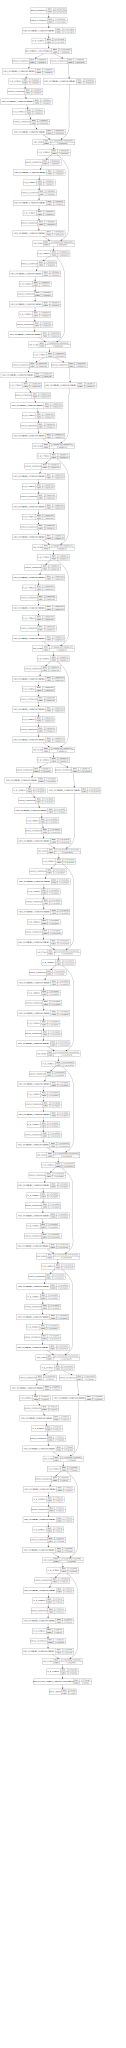

In [155]:
printModel(model)